In [1]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
from matplotlib import animation
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
import skimage
import plotly.graph_objects as go

from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans

import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from statistics import mode
from matplotlib import transforms
import netCDF4

import os
import moviepy.video.io.ImageSequenceClip
from IPython.display import Video

In [2]:
path = "/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-20-00000.nc"
extra_variables = xr.open_dataset(path)
ha = extra_variables.hyai.values
hb = extra_variables.hybi.values
PS = 1e5
Pressures_real = PS*ha+PS*hb

In [3]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'stix'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [4]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
levs = np.array(others.variables['lev'])
lons = np.array(others.variables['lon'])
new = np.flip(levs)
crms = np.arange(1,129,1)
Xs, Zs = np.meshgrid(crms, new)

In [5]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc'
extra_variables = xr.open_dataset(path_to_file)
latitudes = np.squeeze(extra_variables.LAT_20s_to_20n.values)
longitudes = np.squeeze(extra_variables.LON_0e_to_360e.values)
new_lons, new_lats = np.meshgrid(longitudes, latitudes)

In [6]:
sc_convection_proportion = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Quantiative_Analysis/Compressed_Data/SC_Map_K_3_VAE_3312.npy")
csc_convection_proportion = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Quantiative_Analysis/Compressed_Data/CSC_Map_K_3_VAE_3312.npy")
deep_convection_proportion = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Quantiative_Analysis/Compressed_Data/DEEP_Map_K_3_VAE_3312.npy")

In [7]:
Zero_K_P_001_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_001_3.npy")
Zero_K_P_01_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_01_3.npy")
Zero_K_P_1_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_1_3.npy")
Zero_K_P_5_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_5_3.npy")
Zero_K_P_25_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_25_3.npy")
Zero_K_P_75_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_75_3.npy")
Zero_K_P_95_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_95_3.npy")
Zero_K_P_99_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_99_3.npy")
Zero_K_P_999_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_999_3.npy")
Zero_K_P_9999_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_9999_3.npy")
Zero_K_P_50_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_50_3.npy")

Zero_K_P_001_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_001_2.npy")
Zero_K_P_01_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_01_2.npy")
Zero_K_P_1_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_1_2.npy")
Zero_K_P_5_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_5_2.npy")
Zero_K_P_25_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_25_2.npy")
Zero_K_P_75_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_75_2.npy")
Zero_K_P_95_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_95_2.npy")
Zero_K_P_99_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_99_2.npy")
Zero_K_P_999_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_999_2.npy")
Zero_K_P_9999_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_9999_2.npy")
Zero_K_P_50_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_3312_0K_ww_mean_profile_50_2.npy")

Zero_K_P_001_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_0K_ww_mean_profile_001_1.npy")
Zero_K_P_01_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_0K_ww_mean_profile_01_1.npy")
Zero_K_P_1_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_0K_ww_mean_profile_1_1.npy")
Zero_K_P_5_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_0K_ww_mean_profile_5_1.npy")
Zero_K_P_25_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_0K_ww_mean_profile_25_1.npy")
Zero_K_P_75_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_0K_ww_mean_profile_75_1.npy")
Zero_K_P_95_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_0K_ww_mean_profile_95_1.npy")
Zero_K_P_99_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_0K_ww_mean_profile_99_1.npy")
Zero_K_P_999_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_0K_ww_mean_profile_999_1.npy")
Zero_K_P_9999_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_0K_ww_mean_profile_9999_1.npy")
Zero_K_P_50_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_0K_ww_mean_profile_50_1.npy")

Four_K_P_001_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_001_3.npy")
Four_K_P_01_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_01_3.npy")
Four_K_P_1_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_1_3.npy")
Four_K_P_5_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_5_3.npy")
Four_K_P_25_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_25_3.npy")
Four_K_P_75_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_75_3.npy")
Four_K_P_95_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_95_3.npy")
Four_K_P_99_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_99_3.npy")
Four_K_P_999_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_999_3.npy")
Four_K_P_9999_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_9999_3.npy")
Four_K_P_50_profile_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_50_3.npy")

Four_K_P_001_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_001_2.npy")
Four_K_P_01_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_01_2.npy")
Four_K_P_1_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_1_2.npy")
Four_K_P_5_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_5_2.npy")
Four_K_P_25_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_25_2.npy")
Four_K_P_75_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_75_2.npy")
Four_K_P_95_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_95_2.npy")
Four_K_P_99_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_99_2.npy")
Four_K_P_999_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_999_2.npy")
Four_K_P_9999_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_9999_2.npy")
Four_K_P_50_profile_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_50_2.npy")

Four_K_P_001_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_001_1.npy")
Four_K_P_01_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_01_1.npy")
Four_K_P_1_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_1_1.npy")
Four_K_P_5_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_5_1.npy")
Four_K_P_25_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_25_1.npy")
Four_K_P_75_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_75_1.npy")
Four_K_P_95_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_95_1.npy")
Four_K_P_99_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_99_1.npy")
Four_K_P_999_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_999_1.npy")
Four_K_P_9999_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_9999_1.npy")
Four_K_P_50_profile_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/3312_4K_ww_mean_profile_50_1.npy")

In [8]:
path = "/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-20-00000.nc"
extra_variables = xr.open_dataset(path)
ha = extra_variables.hyam.values
hb = extra_variables.hybm.values
SPCAM_P = extra_variables.lev.values

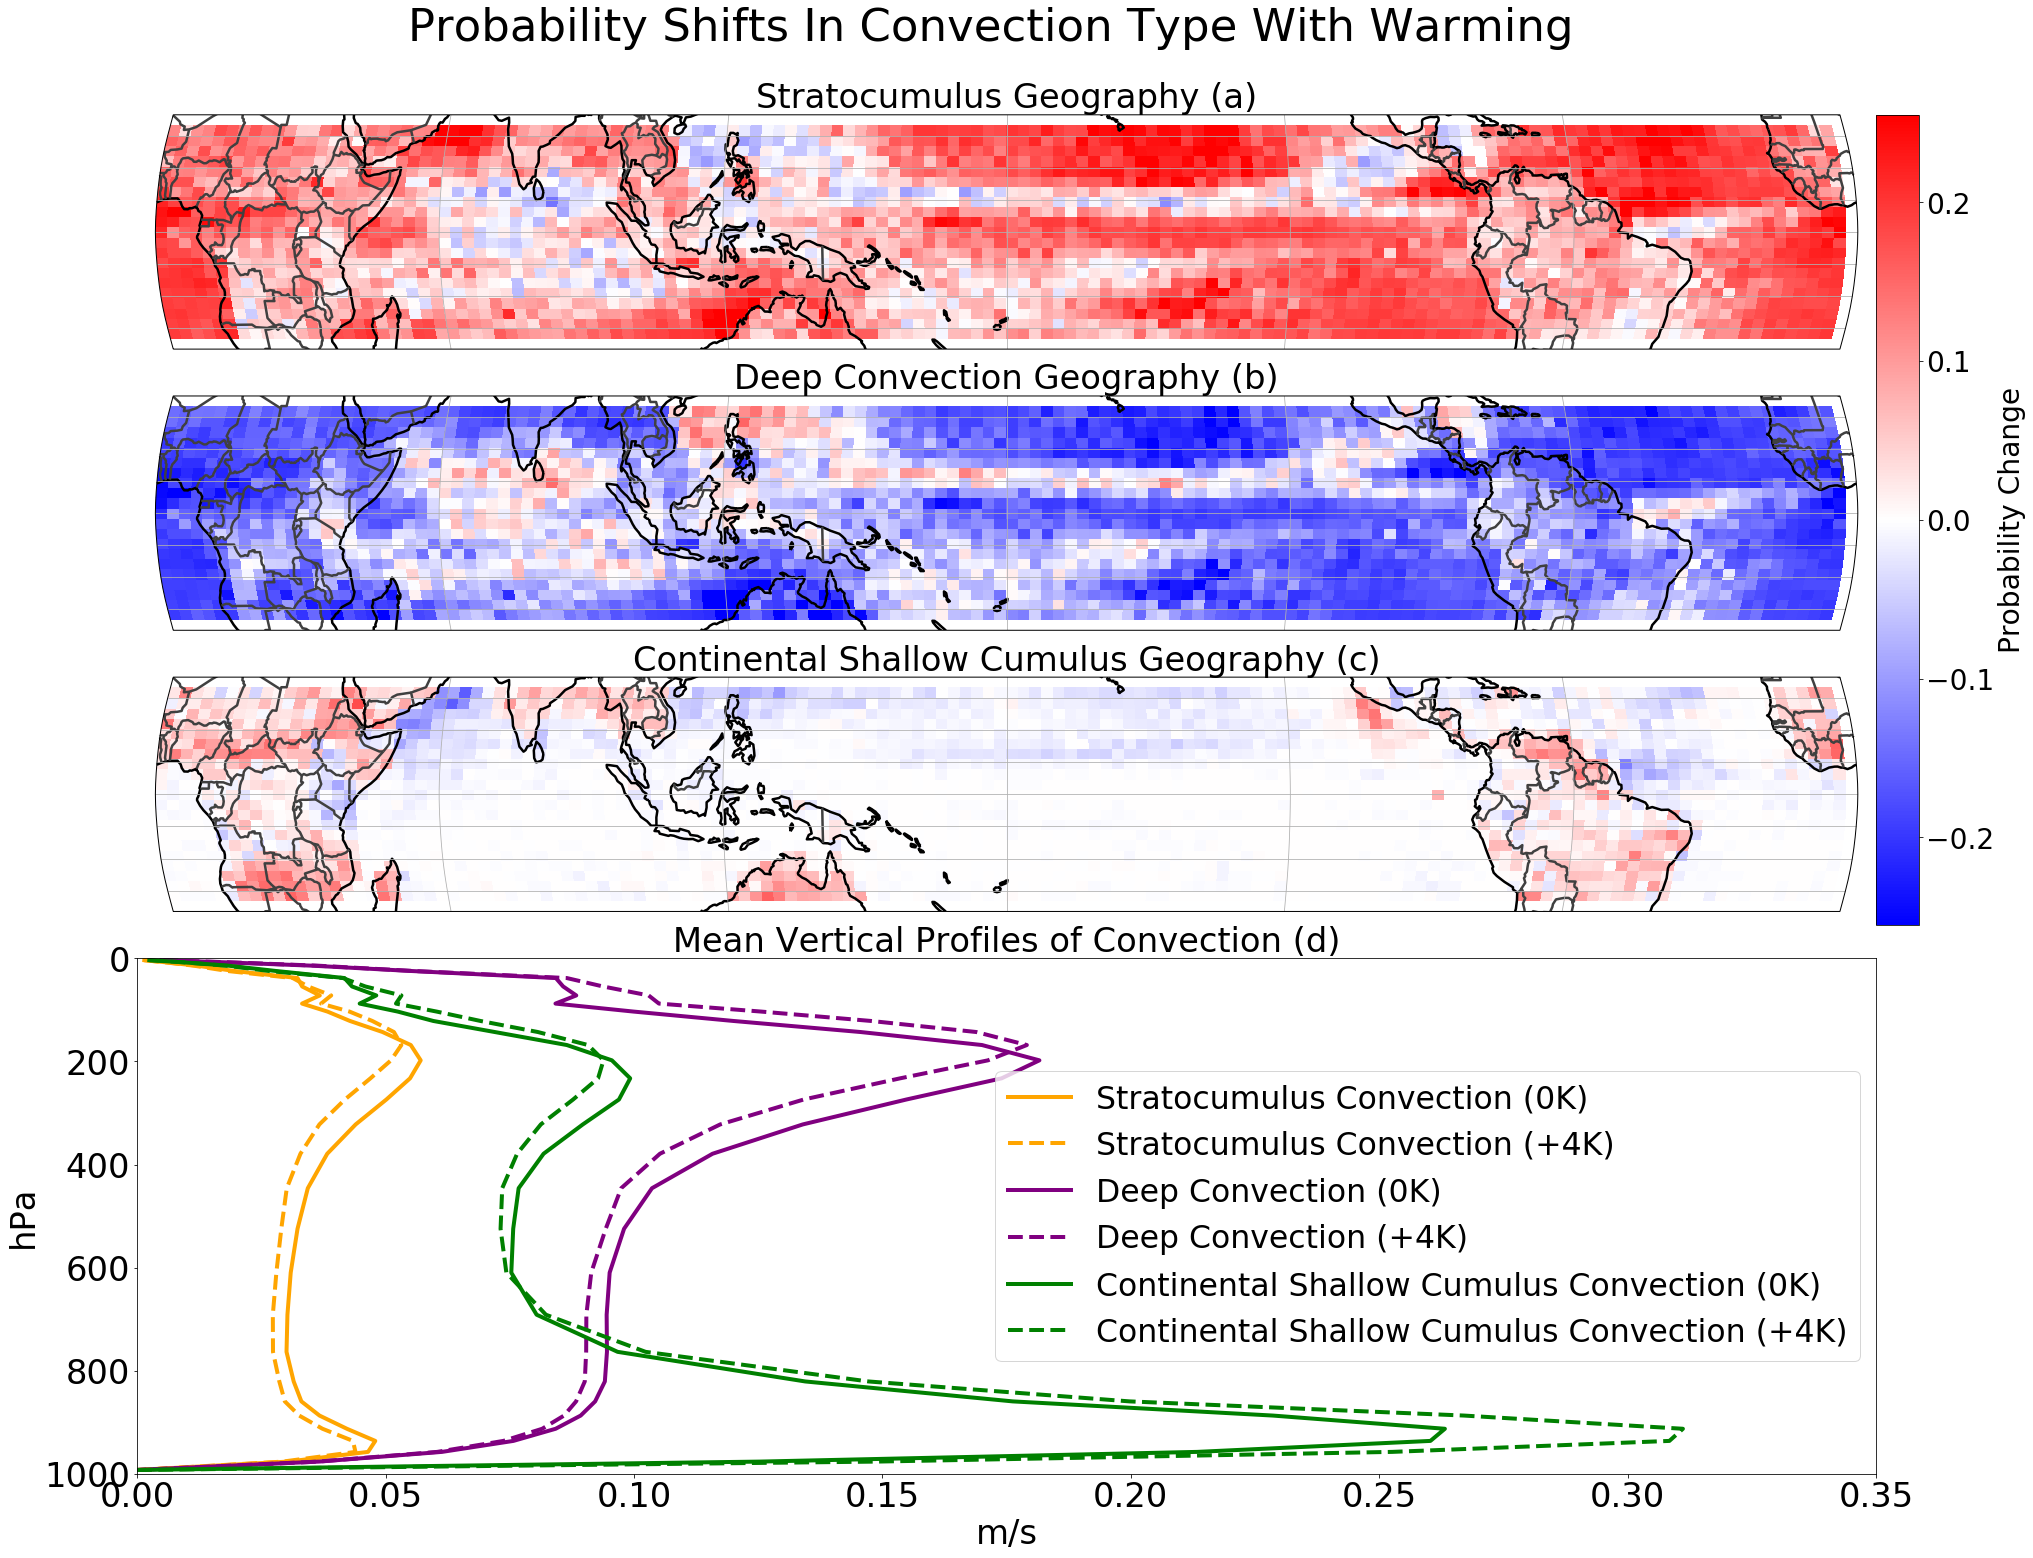

In [24]:
fig, ax = plt.subplots(5,1,figsize=(30,25),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
gs=GridSpec(5,1)

vmin = -1.0*np.max(np.abs(deep_convection_proportion))/1.5
vmax = np.max(np.abs(deep_convection_proportion))/1.5

contour_plot = ax[0].pcolormesh(new_lons, new_lats, sc_convection_proportion*-1, cmap="bwr", transform=ccrs.PlateCarree(), vmin=vmin, vmax = vmax, rasterized=True)
ax[0].coastlines(linewidth=2.5,edgecolor='0.25') 
ax[0].gridlines()
ax[0].add_feature(cfeature.BORDERS,linewidth=2.5,edgecolor='0.25')
ax[0].set_title("Stratocumulus Geography (a)", fontsize = fz*1.5)

contour_plot = ax[1].pcolormesh(new_lons, new_lats, deep_convection_proportion*-1, cmap="bwr", transform=ccrs.PlateCarree(), vmin=vmin, vmax = vmax, rasterized=True)
ax[1].coastlines(linewidth=2.5,edgecolor='0.25')
ax[1].gridlines()
ax[1].add_feature(cfeature.BORDERS,linewidth=2.5,edgecolor='0.25')
ax[1].set_title("Deep Convection Geography (b)", fontsize = fz*1.5)

contour_plot = ax[2].pcolormesh(new_lons, new_lats, csc_convection_proportion*-1, cmap="bwr", transform=ccrs.PlateCarree(), vmin=vmin, vmax = vmax, rasterized=True)
ax[2].coastlines(linewidth=2.5,edgecolor='0.25')
ax[2].gridlines()
ax[2].add_feature(cfeature.BORDERS,linewidth=2.5,edgecolor='0.25')
ax[2].set_title("Continental Shallow Cumulus Geography (c)", fontsize = fz*1.5)

fig.subplots_adjust(right=0.93)
cax_2 = fig.add_axes([0.93, 0.43, 0.02, 0.45])
cb_2 = fig.colorbar(contour_plot, cax=cax_2)
cb_2.set_label('Probability Change', fontsize=fz*1.25)
cb_2.ax.tick_params(labelsize=fz*1.25)

ax1=fig.add_subplot(gs[3:])
ax1.plot(np.flipud(Zero_K_P_50_profile_3), SPCAM_P, c="orange", label="Stratocumulus Convection (0K)")
ax1.plot(np.flipud(Four_K_P_50_profile_3), SPCAM_P, c="orange", linestyle="dashed", label="Stratocumulus Convection (+4K)")
ax1.plot(np.flipud(Zero_K_P_50_profile_2), SPCAM_P, c="purple", label="Deep Convection (0K)")
ax1.plot(np.flipud(Four_K_P_50_profile_2), SPCAM_P, c="purple", linestyle="dashed", label="Deep Convection (+4K)")
ax1.plot(np.flipud(Zero_K_P_50_profile_1), SPCAM_P, c="green", label="Continental Shallow Cumulus Convection (0K)")
cs = ax1.plot(np.flipud(Four_K_P_50_profile_1), SPCAM_P, c="green", linestyle="dashed", label="Continental Shallow Cumulus Convection (+4K)")
ax1.legend(fontsize=fz*1.4)
ax1.set_xlim(0,0.35)
ax1.set_ylim(0,1000)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_title("Mean Vertical Profiles of Convection (d)", fontsize = fz*1.5)
ax1.set_ylabel("hPa", fontsize=fz*1.5)
ax1.set_xlabel("m/s", fontsize=fz*1.5)
ax1.tick_params(axis='y', which='both', labelsize=fz*1.5)
ax1.tick_params(axis='x', which='both', labelsize=fz*1.5)

plt.suptitle("Probability Shifts In Convection Type With Warming", y = 0.94, x = 0.52, fontsize=fz*2.0)
fig.delaxes(ax[3])
fig.delaxes(ax[4])
#fig.delaxes(ax[5])
plt.savefig("../Figures/Figure_4.png", bbox_inches='tight',pad_inches = 0)
plt.savefig("../Figures/Figure_4.pdf", bbox_inches='tight',pad_inches = 0)

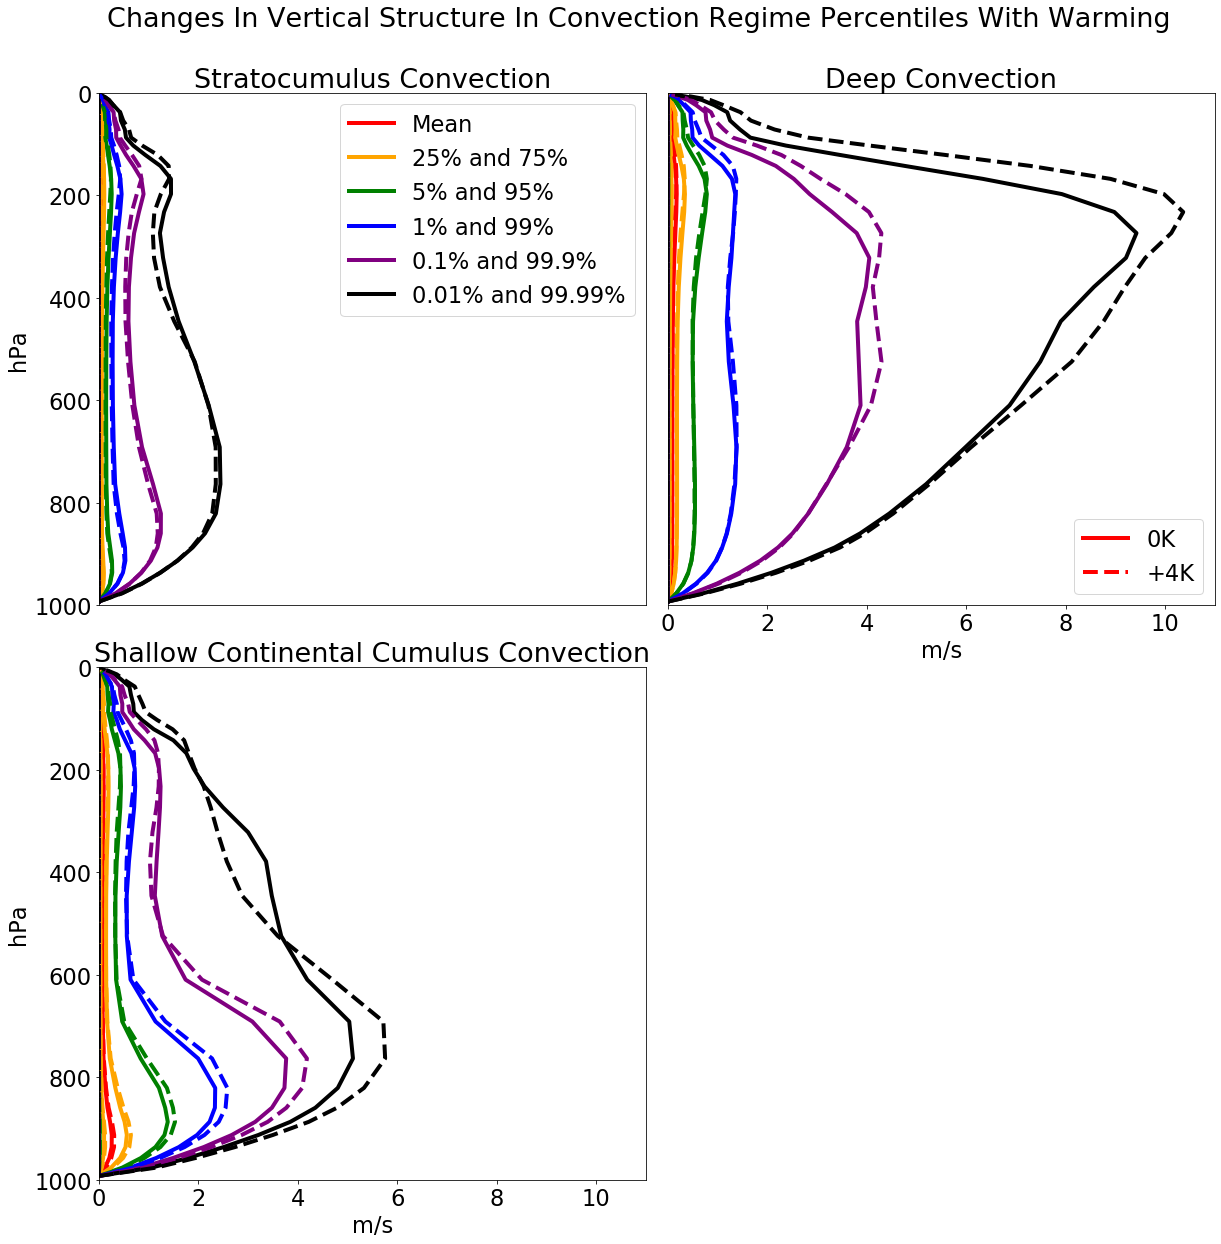

In [119]:
fig, ax = plt.subplots(2,2, figsize=(20,20))

ax[0,0].plot(Zero_K_P_50_profile_3, np.flipud(SPCAM_P), color="red", label="Mean")
ax[0,0].plot(Four_K_P_50_profile_3, np.flipud(SPCAM_P), color="red")
ax[0,0].plot(Zero_K_P_25_profile_3, np.flipud(SPCAM_P), color="orange", label="25% and 75%")
ax[0,0].plot(Zero_K_P_75_profile_3, np.flipud(SPCAM_P), color="orange")
ax[0,0].plot(Zero_K_P_5_profile_3, np.flipud(SPCAM_P), color="green", label="5% and 95%")
ax[0,0].plot(Zero_K_P_95_profile_3, np.flipud(SPCAM_P), color="green")
ax[0,0].plot(Zero_K_P_1_profile_3, np.flipud(SPCAM_P), color="blue", label="1% and 99%")
ax[0,0].plot(Zero_K_P_99_profile_3, np.flipud(SPCAM_P), color="blue")
ax[0,0].plot(Zero_K_P_01_profile_3, np.flipud(SPCAM_P), color="purple", label="0.1% and 99.9%")
ax[0,0].plot(Zero_K_P_999_profile_3, np.flipud(SPCAM_P), color="purple")
ax[0,0].plot(Zero_K_P_001_profile_3, np.flipud(SPCAM_P), color="black", label="0.01% and 99.99%")
ax[0,0].plot(Zero_K_P_9999_profile_3, np.flipud(SPCAM_P), color="black")

ax[0,0].plot(Four_K_P_25_profile_3, np.flipud(SPCAM_P), color="orange", linestyle="dashed")
ax[0,0].plot(Four_K_P_75_profile_3, np.flipud(SPCAM_P), color="orange", linestyle="dashed")
ax[0,0].plot(Four_K_P_5_profile_3, np.flipud(SPCAM_P), color="green", linestyle="dashed")
ax[0,0].plot(Four_K_P_95_profile_3, np.flipud(SPCAM_P), color="green", linestyle="dashed")
ax[0,0].plot(Four_K_P_1_profile_3, np.flipud(SPCAM_P), color="blue", linestyle="dashed")
ax[0,0].plot(Four_K_P_99_profile_3, np.flipud(SPCAM_P), color="blue", linestyle="dashed")
ax[0,0].plot(Four_K_P_01_profile_3, np.flipud(SPCAM_P), color="purple", linestyle="dashed")
ax[0,0].plot(Four_K_P_999_profile_3, np.flipud(SPCAM_P), color="purple", linestyle="dashed")
ax[0,0].plot(Four_K_P_001_profile_3, np.flipud(SPCAM_P), color="black", linestyle="dashed")
ax[0,0].plot(Four_K_P_9999_profile_3, np.flipud(SPCAM_P), color="black", linestyle="dashed")
   
ax[0,0].set_ylim(ax[0,0].get_ylim()[::-1])
ax[0,0].set_ylim(1000,0)
ax[0,0].set_title("Stratocumulus Convection")
ax[0,0].legend(fontsize=fz)
ax[0,0].set_xticks([])
ax[0,0].set_ylabel("hPa")
ax[0,0].set_xlim(0,11)

ax[0,1].plot(Zero_K_P_50_profile_2, np.flipud(SPCAM_P), color="red", label="0K")
ax[0,1].plot(Four_K_P_50_profile_2, np.flipud(SPCAM_P), color="red", linestyle = "dashed", label="+4K")

ax[0,1].plot(Zero_K_P_25_profile_2, np.flipud(SPCAM_P), color="orange")
ax[0,1].plot(Zero_K_P_75_profile_2, np.flipud(SPCAM_P), color="orange")
ax[0,1].plot(Zero_K_P_5_profile_2, np.flipud(SPCAM_P), color="green")
ax[0,1].plot(Zero_K_P_95_profile_2, np.flipud(SPCAM_P), color="green")
ax[0,1].plot(Zero_K_P_1_profile_2, np.flipud(SPCAM_P), color="blue")
ax[0,1].plot(Zero_K_P_99_profile_2, np.flipud(SPCAM_P), color="blue")
ax[0,1].plot(Zero_K_P_01_profile_2, np.flipud(SPCAM_P), color="purple")
ax[0,1].plot(Zero_K_P_999_profile_2, np.flipud(SPCAM_P), color="purple")
ax[0,1].plot(Zero_K_P_001_profile_2, np.flipud(SPCAM_P), color="black")
ax[0,1].plot(Zero_K_P_9999_profile_2, np.flipud(SPCAM_P), color="black")

ax[0,1].plot(Four_K_P_25_profile_2, np.flipud(SPCAM_P), color="orange", linestyle="dashed")
ax[0,1].plot(Four_K_P_75_profile_2, np.flipud(SPCAM_P), color="orange", linestyle="dashed")
ax[0,1].plot(Four_K_P_5_profile_2, np.flipud(SPCAM_P), color="green", linestyle="dashed")
ax[0,1].plot(Four_K_P_95_profile_2, np.flipud(SPCAM_P), color="green", linestyle="dashed")
ax[0,1].plot(Four_K_P_1_profile_2, np.flipud(SPCAM_P), color="blue", linestyle="dashed")
ax[0,1].plot(Four_K_P_99_profile_2, np.flipud(SPCAM_P), color="blue", linestyle="dashed")
ax[0,1].plot(Four_K_P_01_profile_2, np.flipud(SPCAM_P), color="purple", linestyle="dashed")
ax[0,1].plot(Four_K_P_999_profile_2, np.flipud(SPCAM_P), color="purple", linestyle="dashed")
ax[0,1].plot(Four_K_P_001_profile_2, np.flipud(SPCAM_P), color="black", linestyle="dashed")
ax[0,1].plot(Four_K_P_9999_profile_2, np.flipud(SPCAM_P), color="black", linestyle="dashed")
   
ax[0,1].set_ylim(ax[0,1].get_ylim()[::-1])
ax[0,1].set_ylim(1000,0)
ax[0,1].set_title("Deep Convection")
ax[0,1].legend(fontsize=fz)
ax[0,1].set_xlabel("m/s")
ax[0,1].set_yticks([])
ax[0,1].set_xlim(0,11)

ax[1,0].plot(Zero_K_P_50_profile_1, np.flipud(SPCAM_P), color="red")
ax[1,0].plot(Four_K_P_50_profile_1, np.flipud(SPCAM_P), color="red", linestyle="dashed")
ax[1,0].plot(Zero_K_P_25_profile_1, np.flipud(SPCAM_P), color="orange")
ax[1,0].plot(Zero_K_P_75_profile_1, np.flipud(SPCAM_P), color="orange")
ax[1,0].plot(Zero_K_P_5_profile_1, np.flipud(SPCAM_P), color="green")
ax[1,0].plot(Zero_K_P_95_profile_1, np.flipud(SPCAM_P), color="green")
ax[1,0].plot(Zero_K_P_1_profile_1, np.flipud(SPCAM_P), color="blue")
ax[1,0].plot(Zero_K_P_99_profile_1, np.flipud(SPCAM_P), color="blue")
ax[1,0].plot(Zero_K_P_01_profile_1, np.flipud(SPCAM_P), color="purple")
ax[1,0].plot(Zero_K_P_999_profile_1, np.flipud(SPCAM_P), color="purple")
ax[1,0].plot(Zero_K_P_001_profile_1, np.flipud(SPCAM_P), color="black")
ax[1,0].plot(Zero_K_P_9999_profile_1, np.flipud(SPCAM_P), color="black")

ax[1,0].plot(Four_K_P_25_profile_1, np.flipud(SPCAM_P), color="orange", linestyle="dashed")
ax[1,0].plot(Four_K_P_75_profile_1, np.flipud(SPCAM_P), color="orange", linestyle="dashed")
ax[1,0].plot(Four_K_P_5_profile_1, np.flipud(SPCAM_P), color="green", linestyle="dashed")
ax[1,0].plot(Four_K_P_95_profile_1, np.flipud(SPCAM_P), color="green", linestyle="dashed")
ax[1,0].plot(Four_K_P_1_profile_1, np.flipud(SPCAM_P), color="blue", linestyle="dashed")
ax[1,0].plot(Four_K_P_99_profile_1, np.flipud(SPCAM_P), color="blue", linestyle="dashed")
ax[1,0].plot(Four_K_P_01_profile_1, np.flipud(SPCAM_P), color="purple", linestyle="dashed")
ax[1,0].plot(Four_K_P_999_profile_1, np.flipud(SPCAM_P), color="purple", linestyle="dashed")
ax[1,0].plot(Four_K_P_001_profile_1, np.flipud(SPCAM_P), color="black", linestyle="dashed")
ax[1,0].plot(Four_K_P_9999_profile_1, np.flipud(SPCAM_P), color="black", linestyle="dashed")
   
ax[1,0].set_ylim(ax[1,0].get_ylim()[::-1])
ax[1,0].set_ylim(1000,0)
ax[1,0].set_title("Shallow Continental Cumulus Convection")
ax[1,0].set_xlabel("m/s")
ax[1,0].set_ylabel("hPa")
ax[1,0].set_xlim(0,11)
fig.delaxes(ax[1,1])
plt.suptitle("Changes In Vertical Structure In Convection Regime Percentiles With Warming", y=0.94)
plt.subplots_adjust(hspace=0.12, wspace=0.04)

plt.savefig("../Figures/SI_Figure_Vertical_Profiles.png", bbox_inches='tight',pad_inches = 0)
plt.savefig("../Figures/SI_Figure_Vertical_Profiles.pdf", bbox_inches='tight',pad_inches = 0)